Do some Clustering of phenotypic data
- get pheno stuff as a matrix
- take the distance/1-correlation matrix of that
- cluster with scipy cluster
- happiness

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy import cluster as scl
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs

In [8]:
# Load pheno file
#path_root = '/media/yassinebha/database29/Drive/HCP/'
path_root = '/home/yassinebha/Drive/HCP/'
pheno = pd.read_csv(os.path.join(path_root,'subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean.csv'))
use_columns = pheno.columns.get_values() # here all
# Number of subtypes
n_sbt = 7
# Find guys who are missing any of these columns
missing = np.array([pheno[col].isnull().values for col in use_columns]).any(0)
# Don't use these guys
use_pheno = pheno[~missing]

In [9]:
# Show list of columns
list(pheno.columns)

['Age_in_Yrs',
 'Gender',
 'Handedness',
 'Zygosity',
 'Race',
 'Ethnicity',
 'SSAGA_Income',
 'SSAGA_Educ',
 'BMI',
 'BPSystolic',
 'BPDiastolic',
 'PSQI_Score',
 'PicSeq_Unadj',
 'CardSort_Unadj',
 'Flanker_Unadj',
 'PMAT24_A_CR',
 'PMAT24_A_RTCR',
 'ReadEng_Unadj',
 'PicVocab_Unadj',
 'ProcSpeed_Unadj',
 'DDisc_AUC_200',
 'DDisc_AUC_40K',
 'VSPLOT_TC',
 'VSPLOT_CRTE',
 'SCPT_TPRT',
 'SCPT_SEN',
 'SCPT_SPEC',
 'IWRD_TOT',
 'IWRD_RTC',
 'ER40_CR',
 'ER40_CRT',
 'Sadness_Unadj',
 'FearSomat_Unadj',
 'FearAffect_Unadj',
 'AngAggr_Unadj',
 'AngHostil_Unadj',
 'AngAffect_Unadj',
 'LifeSatisf_Unadj',
 'MeanPurp_Unadj',
 'PosAffect_Unadj',
 'Friendship_Unadj',
 'Loneliness_Unadj',
 'PercHostil_Unadj',
 'PercReject_Unadj',
 'EmotSupp_Unadj',
 'InstruSupp_Unadj',
 'PercStress_Unadj',
 'SelfEff_Unadj',
 'Noise_Comp',
 'Odor_Unadj',
 'PainInterf_Tscore',
 'Taste_Unadj',
 'Mars_Final',
 'Endurance_AgeAdj',
 'GaitSpeed_Comp',
 'Dexterity_Unadj',
 'Strength_AgeAdj',
 'NEOFAC_A',
 'NEOFAC_O',
 'NEO

In [11]:
# Make matrix out of the remaining guys
pheno_mat = use_pheno.as_matrix()
# Normalize these guys by column
pheno_norm = (pheno_mat - np.mean(pheno_mat, 0))/np.std(pheno_mat, 0)
# Get the correlation of these
pheno_corr = np.corrcoef(pheno_norm.T)
# And get the distance matrix of that
pheno_dist = scl.hierarchy.distance.pdist(pheno_norm.T)
pheno_dist_mat = scl.hierarchy.distance.squareform(pheno_dist)

In [16]:
def cmap_map(function,cmap):
    """ Applies function (which should operate on vectors of shape 3:
    [r, g, b], on colormap cmap. This routine will break any discontinuous     points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red','green','blue'):         step_dict[key] = map(lambda x: x[0], cdict[key])
    step_list = sum(step_dict.values(), [])
    step_list = array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : array(cmap(step)[0:3])
    old_LUT = array(map( reduced_cmap, step_list))
    new_LUT = array(map( function, old_LUT))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i,key in enumerate(('red','green','blue')):
        this_cdict = {}
        for j,step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j,i]
            elif new_LUT[j,i]!=old_LUT[j,i]:
                this_cdict[step] = new_LUT[j,i]
        colorvector=  map(lambda x: x + (x[1], ), this_cdict.items())
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [17]:
inv = cmap_map(lambda x: 1-x, cm.PRGn)  # the "transformation" = 1-x

NameError: name 'cm' is not defined

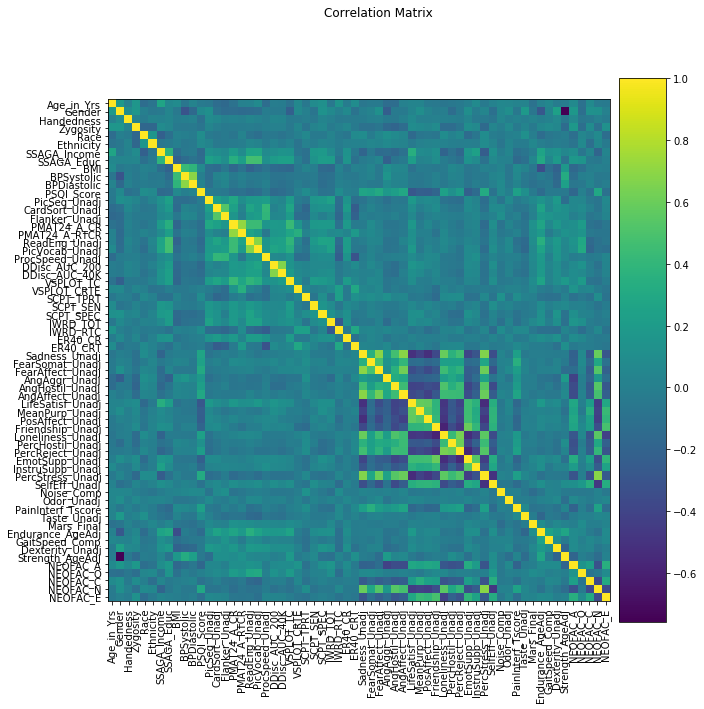

In [12]:
# Show that correlation
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_corr)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(use_columns)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(use_columns, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Correlation Matrix')

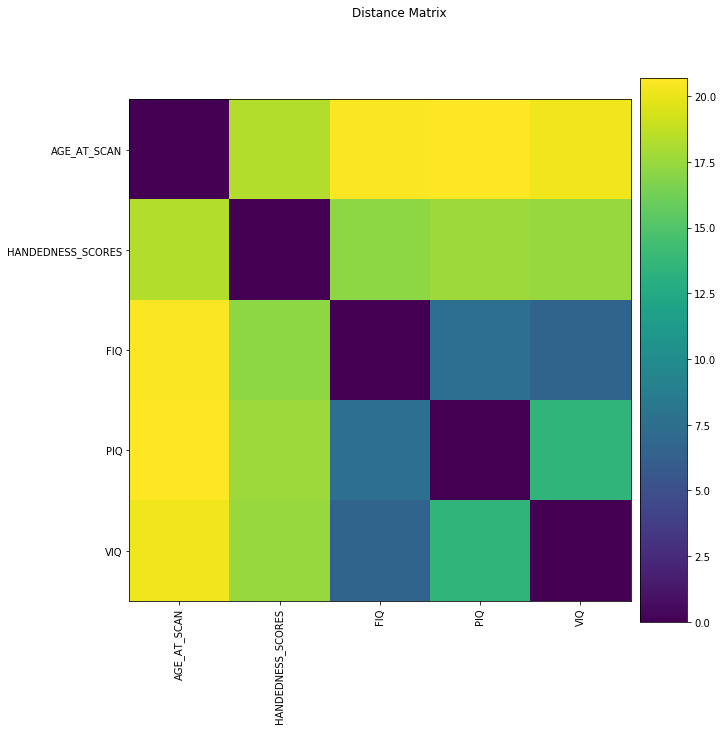

In [8]:
# Show that distance
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_dist_mat)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(use_columns)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(use_columns, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix')

In [9]:
# Now do some clustering on that
link = scl.hierarchy.linkage(pheno_dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

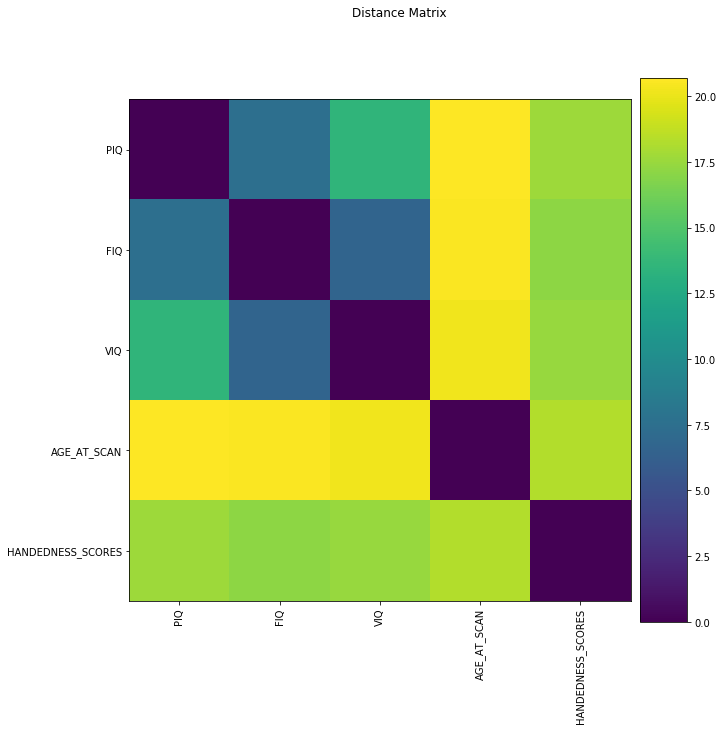

In [10]:
# Plot the distance matrix again, but now ordered by hierarchy
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_dist_mat[order, :][:, order])
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix')

In [11]:
# Here are the groups I found:
for sid in np.unique(part):
    match_cols = [use_columns[x] for x in np.where(part==sid)[0]]
    print('Subtype {} has the following variables:'.format(sid))
    for col in match_cols:
        print('    {}'.format(col))

Subtype 1 has the following variables:
    FIQ
    PIQ
    VIQ
Subtype 2 has the following variables:
    AGE_AT_SCAN
Subtype 3 has the following variables:
    HANDEDNESS_SCORES


In [12]:
# Make a new pheno table with the average scores of these subtypes
data = np.array([np.mean(use_pheno[[use_columns[x] for x in np.where(part==sid)[0]]],1) for sid in np.unique(part)])
ind = use_pheno.index
col_names = ['Subtype_{}'.format(x) for x in np.unique(part)]
sbt_pheno = pd.DataFrame(data=data.T, columns=col_names, index=ind)
# Merge this with the original dataframe so I can get all that other stuff I didn't use
merged_pheno = pd.merge(pheno, sbt_pheno, how='right', left_index=True, right_index=True)

In [13]:
# Look at it (new stuff on the right)
merged_pheno.head()

,SUB_ID,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,FD,FD_scrubbed,session,run,ADOS_sb_sev,ADOS_sc_sev,biv,Subtype_1,Subtype_2,Subtype_3
80,50964,NYU,NYU_0050964,Autism,Autism,12.75,Male,NaN,59.0,106.0,...,0.243671,0.207482,1,1,7.0,9.0,1136863.084,105.000000,12.75,59.0
81,50965,NYU,NYU_0050965,Autism,PDD-NOS,9.25,Male,NaN,48.0,132.0,...,0.217266,0.147379,1,1,1.0,3.0,1261804.657,129.000000,9.25,48.0
82,50966,NYU,NYU_0050966,Autism,PDD-NOS,15.14,Male,NaN,91.0,108.0,...,0.139762,0.130360,1,1,5.0,6.0,1185394.722,107.666667,15.14,91.0
83,50967,NYU,NYU_0050967,Autism,PDD-NOS,9.74,Male,NaN,-89.0,76.0,...,0.202219,0.176899,1,1,7.0,5.0,1061542.291,77.333333,9.74,-89.0
84,50971,NYU,no_filename,Autism,Aspergers,10.24,Male,NaN,81.0,122.0,...,0.205634,0.163792,1,1,8.0,3.0,1132230.559,120.333333,10.24,81.0


In [14]:
# Save the new thing so I can look at it later
merged_pheno.to_csv(out_p, index=False)